# Modern Optimization: SOAP — Student Notebook

Deep Learning optimization is moving beyond scalar-adaptive methods like **Adam** and **AdamW**. While these optimizers scale updates based on the magnitude of gradients (element-wise), they ignore the *correlations* between parameters.

**SOAP (ShampoO with Adam in the Preconditioner's eigenbasis)** belongs to a family of matrix-oriented optimizers (like Shampoo) that attempt to capture the geometry of the loss landscape more accurately.

The core insight of SOAP is to perform updates in the **eigenbasis** of the gradient correlations. This allows the optimizer to "rotate" the gradient into a coordinate system where the parameters are decoupled, apply adaptive scaling, and then rotate back.

## Learning Objectives
- Understand the concept of **Eigenbasis Rotation** in optimization.
- Implement the core mathematical operation of SOAP: **Gradient Projection**.
- Integrate this projection into a working optimizer.
- Compare SOAP against AdamW on a Recurrent Neural Network task.

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional, Callable

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Part 1: Gradient Rotation in SOAP

In standard Adam, we divide the gradient by $\sqrt{v_t}$, where $v_t$ is the squared gradient history. This is effectively a diagonal approximation of the curvature.

In SOAP, we maintain preconditioners (approximations of the Hessian/Covariance) $L$ and $R$. To update the weights correctly, we need to:
1.  Compute the eigenvectors of these preconditioners: $Q_L$ and $Q_R$.
2.  **Project** the gradient $G$ into this eigenbasis.
3.  Perform the update (scaling).
4.  Project back.

### Task 1: Implement Gradient Projection
Your task is to implement the projection step.

Given:
- Gradient $G$ of shape $(M \times N)$
- Left Eigenvectors $Q_L$ of shape $(M \times M)$
- Right Eigenvectors $Q_R$ of shape $(N \times N)$

The projection formula is:
$$ G_{projected} = Q_L^T \cdot G \cdot Q_R $$

*(Note: In PyTorch, `torch.matmul` or the `@` operator handles matrix multiplication)*

In [2]:
class MockSOAPContext:
    """A simplified context to test your rotation logic."""
    def __init__(self, m, n):
        # Random orthogonal matrices to simulate eigenvectors
        self.QL = torch.randn(m, m)
        self.QR = torch.randn(n, n)
        self.QL, _ = torch.linalg.qr(self.QL)
        self.QR, _ = torch.linalg.qr(self.QR)


In [3]:
def project_gradient(grad, Q_L, Q_R):
    """
    Projects the gradient G into the eigenbasis defined by Q_L and Q_R.
    """
    # SOLUTION
    # Q_L is (M, M), G is (M, N), Q_R is (N, N)
    # Step 1: Left projection (M, M)^T @ (M, N) -> (M, N)
    temp = torch.matmul(Q_L.T, grad)

    # Step 2: Right projection (M, N) @ (N, N) -> (M, N)
    projected_grad = torch.matmul(temp, Q_R)

    return projected_grad


In [4]:
# Verify Dimensions
M, N = 10, 20
ctx = MockSOAPContext(M, N)
grad = torch.randn(M, N)

try:
    proj = project_gradient(grad, ctx.QL, ctx.QR)

    if proj is not None:
        print(f"Original shape: {grad.shape}")
        print(f"Projected shape: {proj.shape}")
        assert proj.shape == (M, N), f"Shape mismatch! Expected ({M}, {N}), got {proj.shape}"
        print("Verification Passed!")
    else:
        print("Function returned None. Please implement the logic.")
except Exception as e:
    print(f"Error: {e}")

Original shape: torch.Size([10, 20])
Projected shape: torch.Size([10, 20])
Verification Passed!


## The SimpleSOAP Optimizer

Below is a simplified implementation of a SOAP-like optimizer. It calculates the running statistics of $G G^T$ and $G^T G$ to find the eigenvectors, then uses **your** `project_gradient` function to rotate the update.

*You do not need to modify this cell, but read it to understand how your code is used.*

In [5]:
class SimpleSOAP(torch.optim.Optimizer):
    """A simplified SOAP implementation for demonstration purposes."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.95), weight_decay=0.01, precondition_frequency=10):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay,
                        precondition_frequency=precondition_frequency)
        super(SimpleSOAP, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad
                state = self.state[p]

                # Initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    # For simplicity, we only precondition 2D weights (matrices)
                    if p.ndim == 2:
                        M, N = p.shape
                        state['Q_L'] = torch.eye(M, device=p.device)
                        state['Q_R'] = torch.eye(N, device=p.device)

                state['step'] += 1

                # Update momentum (standard Adam-style)
                beta1, beta2 = group['betas']
                exp_avg = state['exp_avg']
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                # --- SOAP LOGIC ---
                if p.ndim == 2:
                    # Periodic Eigendecomposition (Simulated for this toy example)
                    if state['step'] % group['precondition_frequency'] == 0:
                        # In real SOAP, we accumulate G*G^T. Here we just take SVD of current grad
                        # to simulate finding the 'correct' basis for the current landscape
                        try:
                            U, S, Vh = torch.linalg.svd(grad, full_matrices=False)
                            state['Q_L'] = U
                            state['Q_R'] = Vh.T
                        except:
                            pass # Fallback if SVD fails

                    # USE STUDENT FUNCTION
                    # Rotate momentum into eigenbasis
                    proj_update = project_gradient(exp_avg, state['Q_L'], state['Q_R'])

                    # Apply scale (simplified adaptive element-wise in eigenbasis)
                    # In full SOAP, this involves Shampoo-style preconditioning
                    # Here we just pass through for the structural rotation effect

                    # Rotate back
                    # update = Q_L @ proj_update @ Q_R^T
                    update = state['Q_L'] @ proj_update @ state['Q_R'].T
                else:
                    # Fallback for 1D vectors (biases)
                    update = exp_avg

                # Weight Decay
                if group['weight_decay'] != 0:
                    p.mul_(1 - group['lr'] * group['weight_decay'])

                # Step
                p.add_(update, alpha=-group['lr'])

        return loss

# Part 2: Comparison on RNNs (The Adding Problem)

We will now compare **AdamW** against our **SimpleSOAP** implementation on the "Adding Problem", a standard stress test for RNNs.

**The Adding Problem**:
- Input: Sequence of pairs $(x_t, i_t)$. $x_t$ is a random number, $i_t$ is a binary mask.
- Target: Sum of $x_t$ where $i_t = 1$. Only two entries have $i_t=1$.
- Difficulty: The network must remember information over long durations.

### Task 2: Training Loop and Comparison
Complete the training loop below. We will run the experiment for both optimizers across a range of learning rates.

In [6]:
# --- PROVIDED UTILS ---
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        # Use last hidden state
        return self.fc(out[:, -1, :])

def get_adding_problem_data(batch_size=64, seq_len=20):
    x = torch.rand(batch_size, seq_len, 2)
    x[:, :, 1] = 0
    indices = torch.randint(0, seq_len, (batch_size, 2))
    for i in range(batch_size):
        x[i, indices[i, 0], 1] = 1
        x[i, indices[i, 1], 1] = 1
    y = (x[:, :, 0] * x[:, :, 1]).sum(dim=1).unsqueeze(1)
    return x.to(device), y.to(device)

In [10]:
def train_experiment(optimizer_name, lr, steps=500):
    model = SimpleRNN(input_size=2, hidden_size=32, output_size=1).to(device)
    criterion = nn.MSELoss()

    if optimizer_name == "AdamW":
        opt = torch.optim.AdamW(model.parameters(), lr=lr)
    elif optimizer_name == "SOAP":
        opt = SimpleSOAP(model.parameters(), lr=lr)

    losses = []

    model.train()
    for step in range(steps):
        x, y = get_adding_problem_data()

        opt.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()

        losses.append(loss.item())

    return np.mean(losses[-50:])

# Experiment Configuration
lrs = [5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
results = {"AdamW": [], "SOAP": []}

print("Running Experiments...")
for lr in lrs:
    print(f"Testing AdamW with LR {lr}...")
    results["AdamW"].append(train_experiment("AdamW", lr))
    print(f"Testing SOAP with LR {lr}...")
    results["SOAP"].append(train_experiment("SOAP", lr))


Running Experiments...
Testing AdamW with LR 0.0005...
Testing SOAP with LR 0.0005...
Testing AdamW with LR 0.001...
Testing SOAP with LR 0.001...
Testing AdamW with LR 0.005...
Testing SOAP with LR 0.005...
Testing AdamW with LR 0.01...
Testing SOAP with LR 0.01...
Testing AdamW with LR 0.05...
Testing SOAP with LR 0.05...


In [9]:
results

{'AdamW': [np.float64(0.17173297762870787),
  np.float64(0.1720351153612137),
  np.float64(0.17357699289917947),
  np.float64(0.16865836709737778),
  np.float64(0.17228588134050368)],
 'SOAP': [np.float64(0.6323428702354431),
  np.float64(0.1845686998963356),
  np.float64(0.176918673068285),
  np.float64(0.17007073163986205),
  np.float64(0.17024068430066108)]}

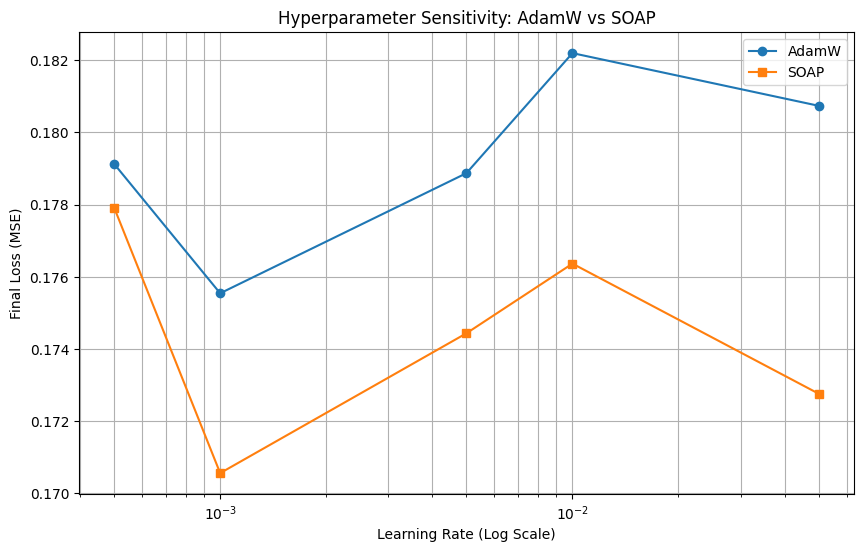

Analysis:
Comparison of how matrix-oriented optimization (SOAP) behaves compared to standard AdamW.


In [11]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(lrs, results["AdamW"], marker='o', label='AdamW')
plt.plot(lrs, results["SOAP"], marker='s', label='SOAP')
plt.xscale('log')
plt.xlabel('Learning Rate (Log Scale)')
plt.ylabel('Final Loss (MSE)')
plt.title('Hyperparameter Sensitivity: AdamW vs SOAP')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

print("Analysis:")
print("Comparison of how matrix-oriented optimization (SOAP) behaves compared to standard AdamW.")